## Train sea lion classifier with a convnet

In [1]:
INPUT_DIR = '../../input/kaggle-sea-lion/02/'
OUTPUT_DIR = '../../output/kaggle-sea-lion/05/'
#IMAGE_DIMS = (148,148,3)
IMAGE_DIMS = (84,84,3)
#IMAGE_DIMS = (32,32,3)

INPUT_DATASET_NAME = 'lion-patches-30px'
SAVE_WEIGHTS_FILE = OUTPUT_DIR + 'last-weights.h5'
LOAD_WEIGHTS_FILE = SAVE_WEIGHTS_FILE

RECREATE_OUTPUT_DIR = True
RUN_TRAINING = True

OUTPUT_WEIGHT = (0,0,1,0,0,1)
TRAIN_EPOCHS = 3

BATCH_SIZE=24

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import sklearn
import os
import glob

import keras
from keras.preprocessing.image import ImageDataGenerator

from modules.logging import logger
import modules.utils as utils
from modules.utils import Timer
import modules.logging
import modules.cnn as cnn
import modules.lions as lions

Using TensorFlow backend.


## Prepare

### Prepare output dir

In [3]:
utils.mkdirs(OUTPUT_DIR, dirs=['tf-logs','weights'], recreate=RECREATE_OUTPUT_DIR)
modules.logging.setup_file_logger(OUTPUT_DIR + 'out.log')
TF_LOGS_DIR = OUTPUT_DIR + 'tf-logs/'
WEIGHTS_DIR = OUTPUT_DIR + 'weights/'
input_dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
temp_file = OUTPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS) + '.npy'

logger.info('Output dirs created')

2017-04-17 01:48:06,839 INFO Output dirs created


### Prepare CNN model

In [4]:
logger.info('Load CNN model')
#model = lions.convnet_alexnet2_lion_keras(IMAGE_DIMS)
model = lions.convnet_simple_lion_keras(IMAGE_DIMS)
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

if(LOAD_WEIGHTS_FILE!=None and os.path.isfile(LOAD_WEIGHTS_FILE)):
    logger.info('Loading previous weights...')
    model.load_weights(LOAD_WEIGHTS_FILE)

2017-04-17 01:48:06,847 INFO Load CNN model


### Prepare train, validate and test data flows

In [5]:
logger.info('Using dataset ' + input_dataset_path + ' as input')
h5file = h5py.File(input_dataset_path, 'r')

image_randomize_generator = ImageDataGenerator(
        featurewise_center=True,
        samplewise_center=False,
        featurewise_std_normalization=True,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=360,
        width_shift_range=0,
        height_shift_range=0,
        horizontal_flip=False,
        vertical_flip=False)

logger.info('preparing train data')
train_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=0.1)
train_balance_generator = utils.ClassBalancerGeneratorXY(train_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_file=temp_file)
train_balance_generator.setup_flow(0, 0.2)
train_generator = utils.image_augmentation_xy(train_balance_generator.flow(), image_randomize_generator)
logger.info('train size=' + str(train_balance_generator.size) + ' batches=' + str(train_balance_generator.nr_batches))


logger.info('preparing valid data')
valid_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=0.1)
valid_balance_generator = utils.ClassBalancerGeneratorXY(valid_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_file=temp_file)
valid_balance_generator.setup_flow(0.7, 0.8)
logger.info('valid size=' + str(valid_balance_generator.size) + ' batches=' + str(valid_balance_generator.nr_batches))



logger.info('preparing test data')
test_batch_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0, end_ratio=0.1)
test_balance_generator = utils.ClassBalancerGeneratorXY(test_batch_generator,
                                                         image_augmentation=image_randomize_generator,
                                                         output_weight=OUTPUT_WEIGHT,
                                                         max_augmentation_ratio=0,
                                                         max_undersampling_ratio=1,
                                                         enforce_max_ratios=False,
                                                         tmp_file=temp_file)
test_balance_generator.setup_flow(0.8, 0.9)
logger.info('test size=' + str(test_balance_generator.size) + ' batches=' + str(test_balance_generator.nr_batches))

#FIXME when using 1 on end ratio size and nr_batches gets negative (h5 batch generator, not balancer...)

2017-04-17 01:48:07,046 INFO Using dataset ../../input/kaggle-sea-lion/02/lion-patches-30px-84-84.h5 as input
2017-04-17 01:48:07,049 INFO preparing train data
2017-04-17 01:48:07,051 INFO loading input data for class distribution analysis...
2017-04-17 01:48:07,052 INFO loading Y from raw dataset
2017-04-17 01:48:07,054 INFO > [started] generator dump...


7488/7433

2017-04-17 01:48:08,541 INFO > [done]    generator dump (1487.132 ms)
2017-04-17 01:48:08,542 INFO saving Y to temp file ../../output/kaggle-sea-lion/05/lion-patches-30px-84-84.h5.npy
2017-04-17 01:48:08,548 INFO raw sample class distribution
2017-04-17 01:48:08,549 INFO 0: 487
2017-04-17 01:48:08,551 INFO 1: 326
2017-04-17 01:48:08,552 INFO 2: 1883
2017-04-17 01:48:08,553 INFO 3: 763
2017-04-17 01:48:08,554 INFO 4: 726
2017-04-17 01:48:08,556 INFO 5: 3248
2017-04-17 01:48:08,557 INFO overall output samples per class: 326
2017-04-17 01:48:08,558 INFO augmentation/undersampling ratio per class
2017-04-17 01:48:08,560 INFO SETUP FLOW 0 1
2017-04-17 01:48:08,561 INFO output distribution
2017-04-17 01:48:08,562 INFO 0: 0.0 (0.0)
2017-04-17 01:48:08,563 INFO 1: 0.0 (0.0)
2017-04-17 01:48:08,565 INFO 2: 0.173127987254 (326.0)
2017-04-17 01:48:08,566 INFO 3: 0.0 (0.0)
2017-04-17 01:48:08,567 INFO 4: 0.0 (0.0)
2017-04-17 01:48:08,569 INFO 5: 0.100369458128 (326.0)
2017-04-17 01:48:08,570 INFO 

In [6]:
#logger.info('INPUT DATASET DATA')
#dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
#with h5py.File(input_dataset_path, 'r') as h5file:
#    logger.info('generator')
#    input_generator = utils.BatchGeneratorXYH5(h5file, start_ratio=0.001, end_ratio=0.0012, batch_size=64)
#    X, Y = utils.dump_xy_to_array(input_generator.flow(), input_generator.size, x=True, y=True)
#    utils.show_images(X, image_labels=utils.onehot_to_label(Y), group_by_label=False, cols=10, is_bgr=True, size=2)
#
#    logger.info('x ' + str(np.shape(X)))
#    logger.info('y ' + str(np.shape(Y)))
#    logger.info(str(utils.class_distribution(Y)))

logger.info('BALANCE GENERATOR DATA')
dataset_path = INPUT_DIR + utils.dataset_name(INPUT_DATASET_NAME, IMAGE_DIMS)
X_train, Y_train = utils.dump_xy_to_array(train_generator, train_balance_generator.size, x=False, y=True)
#logger.info('x ' + str(np.shape(X_train)))
logger.info('y ' + str(np.shape(Y_train)))
logger.info(str(utils.class_distribution(Y_train)))

#for xs,ys in train_balance_generator.flow():
#    utils.show_images(xs, image_labels=utils.onehot_to_label(ys), cols=10, is_bgr=True, size=2)
#    break

2017-04-17 01:48:08,778 INFO BALANCE GENERATOR DATA
2017-04-17 01:48:08,780 INFO > [started] generator dump...
2017-04-17 01:48:08,781 INFO starting new flow...
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


192/130

2017-04-17 01:48:09,503 INFO > [done]    generator dump (723.419 ms)
2017-04-17 01:48:09,505 INFO y (130, 6)
2017-04-17 01:48:09,508 INFO [ 0  0 83  0  0 47]


## Train model

In [7]:
if(RUN_TRAINING):
    logger.info('Starting CNN training...')
    history = model.fit_generator(train_generator,
                  steps_per_epoch = train_balance_generator.nr_batches,
                  nb_epoch = TRAIN_EPOCHS,
                  callbacks = cnn.get_callbacks_keras(model, WEIGHTS_DIR, TF_LOGS_DIR),
                  validation_data = valid_balance_generator.flow(), 
                  validation_steps = valid_balance_generator.nr_batches,
                  verbose = 1)

    if(SAVE_WEIGHTS_FILE!=None):
        logger.info('Saving last weights...')
        model.save_weights(SAVE_WEIGHTS_FILE)

2017-04-17 01:48:09,517 INFO Starting CNN training...
/usr/local/lib/python3.4/dist-packages/ipykernel/__main__.py:9: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=3, callbacks=None, validation_steps=2, epochs=3, validation_data=<generator..., verbose=1)`


Epoch 1/3


/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:500: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/usr/local/lib/python3.4/dist-packages/Keras-2.0.2-py3.4.egg/keras/preprocessing/image.py:508: UserWarning: This ImageDataGenerator specifies `featurewise_std_normalization`, but it hasn'tbeen fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


2/3 [===================>..........] - ETA: 3s - loss: 1.5733 - acc: 0.2812

2017-04-17 01:48:18,567 INFO starting new flow...


3/3 [==============================] - 10s - loss: 1.4260 - acc: 0.3750 - val_loss: 0.9921 - val_acc: 0.3516
Epoch 2/3
3/3 [==============================] - 9s - loss: 0.7415 - acc: 0.6094 - val_loss: 0.7785 - val_acc: 0.6875
Epoch 3/3
3/3 [==============================] - 9s - loss: 0.8273 - acc: 0.4792 - val_loss: 0.9164 - val_acc: 0.2734

2017-04-17 01:48:39,443 INFO Saving last weights...


### Epoch accuracy/loss

2017-04-17 01:48:39,504 INFO Training info


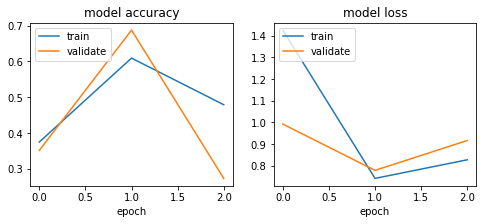

In [8]:
if(RUN_TRAINING):
    logger.info('Training info')
    cnn.show_training_info_keras(history)

### Confusion matrix

In [9]:
cnn.evaluate_dataset_keras(test_balance_generator.flow(), 
                       test_balance_generator.nr_batches, 
                       test_balance_generator.size, 
                       model, 
                       class_labels=[0,1,2,3,4,5])

2017-04-17 01:48:39,897 INFO Evaluating model performance (65 samples)...
2017-04-17 01:48:39,900 INFO starting new flow...
2017-04-17 01:48:42,224 INFO Accuracy: 0.359375 - Loss: 0.837044000626
2017-04-17 01:48:42,225 INFO Predicting Y for detailed analysis...
/notebooks/datascience-snippets/kaggle-sea-lion/modules/cnn.py:66: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
  if(self.y_ds==None):
2017-04-17 01:48:45,603 INFO Number of test samples: 65
2017-04-17 01:48:45,605 INFO Kappa score: 0.0 (-1 bad; 0 just luck; 1 great)
/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
2017-04-17 01:48:45,609 INFO 
             precision    recall  f1-score   support

          0       0.55      1.00      0.71        36
          1       0.00      0.00 

ValueError: At least one label specified must be in y_true

In [ ]:
a = test_balance_generator.flow()
cnn.show_predictions(a, 10, model)


In [ ]:
cm = np.array([[1,2],
               [3,4]])

In [ ]:
np.sum(cm, axis=0)

In [ ]:
acc = cm.diagonal()/np.sum(cm, axis=0)
class_labels = range(len(cm))
acc_class = cm.diagonal()/np.sum(cm, axis=0)
for i,acc in enumerate(acc_class):
    logger.info(str('{}: {:.1f}%'.format(class_labels[i], acc_class[i]*100)))


In [ ]:
class_labels = range(5)
class_labels = [str(s) for s in class_labels]
print(class_labels)